In [1]:
import json
from types import *
from dataloader import *
from util import *
from graphs import *
from agreement import *
from scoring import *

data = []
files = [f'../annotated/{x}' for x in os.listdir('../annotated/')]
files = sorted(files)
files = [x for x in files if 'batch_2_rachel' not in x] # Exclude corrupted file(s)

print(f'Loading files: {files}\n')

# Add file and append user's name
counter = 0
batches = set([int(x.split('.')[-2].split('_')[-2]) for x in files])
for batch_num in batches:
    for filename in [x for x in files if ('batch_' + str(batch_num)) in x]:
        with open(filename) as f:
            individual_annotation = json.load(f)
            for entry in individual_annotation:
                entry['user'] = filename.split('.')[-2].split('_')[-1]
                entry['batch'] = batch_num
                entry['hit_id'] = entry['id']
                entry['id'] += counter
            data += individual_annotation
    counter += len(individual_annotation)

print(f'Found users: {set([sent["user"] for sent in data])}\n')

data = consolidate_edits(data)          # Adds 'edits' field
data = consolidate_annotations(data)    # Adds 'processed_annotations' field
data = add_simpeval_scores(data, json=True)        # Adds 'simpeval_scores' field

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json', '../annotated/batch_3_anton.json', '../annotated/batch_3_ayush.json', '../annotated/batch_3_kelly.json', '../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json']

Found users: {'anton', 'vishnesh', 'rachel', 'vinayak', 'ayush', 'kelly'}

Couldn't process grammar for annotation: ['positive', '', '', '']
Couldn't process grammar for annotation: ['positive', 'minor', '', '']
Couldn't process grammar for annotation: ['positive', 'a lot', '', '']
Couldn't process grammar for annotation: ['positive', 'somewhat', '', '']
Couldn't process grammar for annotation: ['positive', 'somewhat', '', '']
Couldn't process grammar for annotation: ['positive', 'a lot', '', '']
Couldn't process grammar for annotation: ['positive', 'minor', '', '']


In [3]:
# To delete: creates MUSS batch
out = copy.deepcopy(data)
simpeval = []
files = [i for j in [[f'../simpeval/{x}/{y}' for y in os.listdir('../simpeval/'+x)] for x in os.listdir('../simpeval/')] for i in j]
for filename in files:
    with open(filename) as f:
        individual_annotation = json.load(f)
        simpeval += individual_annotation
outMuss = []
for i in range(len(out)):
    sent = out[i]
    system = sent['system']
    simpeval_sents = [entry for entry in simpeval if entry['Original'] == sent['original']]
    final = []
    for entry in simpeval_sents:
        for sentence_type in ['Deletions', 'Paraphrases', 'Splittings']:
            for entry_sent in entry[sentence_type]:
                if entry_sent[2] == 'systems/muss_untokenized.txt':
                    outMuss.append(entry_sent[1])
                    final.append({'sentence_type': sentence_type.lower(), 'score': entry_sent[0], 'spans': entry_sent[3:]})
    scores = [x['score'] for x in final]
    out[i]['simpeval_scores'] = scores


muss = []
for sent in outMuss:
    if sent not in muss:
        muss.append(sent)

orig_sent = [x['original'] for x in out]
orig = []
for sent in orig_sent:
    if sent not in orig:
        orig.append(sent)

batches = [range(0,10), range(10,20), range(20,24), range(24,28)]

outs = []
for batch in batches:
    out = []
    for id_ in batch:
        simp_spans = []
        if '||' in muss[id_]:
            simp_spans.append([
                2,
                muss[id_].index('||'),
                muss[id_].index('||') + 2,
                0
            ])
        out.append({
            'id': id_,
            'original': orig[id_],
            "original_spans": [],
            'simplified': muss[id_],
            "simplified_spans": simp_spans,
            'system': 'systems/muss_untokenized.txt'
        })
    outs.append(out)

b1 = outs[0] + outs[2]
b2 = outs[1] + outs[3]

id_ = 0
for sent in b1:
    sent['id'] = id_
    id_ += 1

id_ = 0
for sent in b2:
    sent['id'] = id_
    id_ += 1

num = 5
with open(f'../batches/batch_{num}.json', 'w', encoding='utf-8') as f:
    json.dump(b1, f, ensure_ascii=False, indent=4)

num = 6
with open('../batches/batch_6.json', 'w', encoding='utf-8') as f:
    json.dump(b2, f, ensure_ascii=False, indent=4)

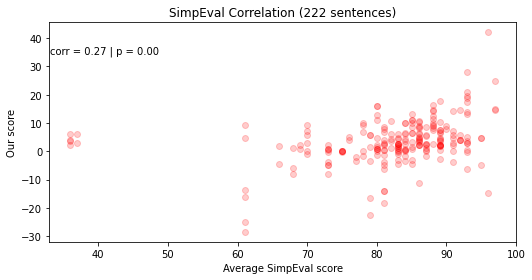

In [24]:
parameters = {
    'good_deletion': 7,
    'good_trivial_insertion': 8,
    'good_insertion': 2,
    'good_paraphrase': 2,
    'good_syntax': 6,
    'grammar_error': -1.5,
    'content_error': -2,
    'size_calculation': 'log'
}

data = calculate_sentence_scores(data, parameters)

# Show the agreement with SimpEval
simpeval_agreement(data)

In [25]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

def series(data, good_deletion, good_trivial_insertion, good_insertion, good_paraphrase, good_syntax, grammar_error, content_error, size_calculation, average, user):
    edit_bonuses = {
        'good_deletion': good_deletion,
        'good_trivial_insertion': good_trivial_insertion,
        'good_insertion': good_insertion,
        'good_paraphrase': good_paraphrase,
        'good_syntax': good_syntax,
        'grammar_error': grammar_error,
        'content_error': content_error,
        'size_calculation': size_calculation
    }

    selected_data = data
    if user != 'all':
        selected_data = [sent for sent in selected_data if sent['user'] == user]

    selected_data = calculate_sentence_scores(selected_data, edit_bonuses)
    simpeval_agreement(selected_data, average)
    return()
interact(
    series, 
    data=[data], 
    good_deletion=(-20,20,0.5), 
    good_trivial_insertion=(-20,20,0.5), 
    good_insertion=(-20,20,0.5), 
    good_paraphrase=(-20,20,0.5), 
    good_syntax=(-20,20,0.5), 
    grammar_error=(-20,20,0.5), 
    content_error=(-20,20,0.5),
    size_calculation=['linear', 'log', 'square', 'none'],
    average=[True, False],
    user=['all'] + sorted(list(set([sent['user'] for sent in data])))
)

interactive(children=(Dropdown(description='data', options=([{'id': 0, 'original': 'The wounds inflicted by a …

<function __main__.series(data, good_deletion, good_trivial_insertion, good_insertion, good_paraphrase, good_syntax, grammar_error, content_error, size_calculation, average, user)>

In [14]:
# Get a looser "sentence quality" annotation information

# sorted([(i, len(sent['processed_annotations'])) for i, sent in enumerate(data)], key=lambda x: x[1], reverse=True)
ann = data[174]['processed_annotations']
get_sent_info(data[174])

'vinayak - Batch 2, HIT 25 (ID 74)'

In [15]:
# sorted([(i, avg(sent['simpeval_scores'])) for i, sent in enumerate(data)], key=lambda x: x[1], reverse=True)
ann = data[40]['processed_annotations']
get_sent_info(data[40])

'anton - Batch 1, HIT 41 (ID 40)'

In [16]:
ann[1]

{'edit_type': 'substitution',
 'id': 0,
 'information_impact': <Information.SAME: 'Same Information'>,
 'type': <Quality.QUALITY: 'No Error'>,
 'grammar_error': False,
 'error_type': None,
 'rating': 2,
 'size': 0.011834319526627219,
 'score': 0.8743517920722712}